# Strategy testing

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\konstantinos\AppData\Local\Temp\ipykernel_13548\2573691268.py:73: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

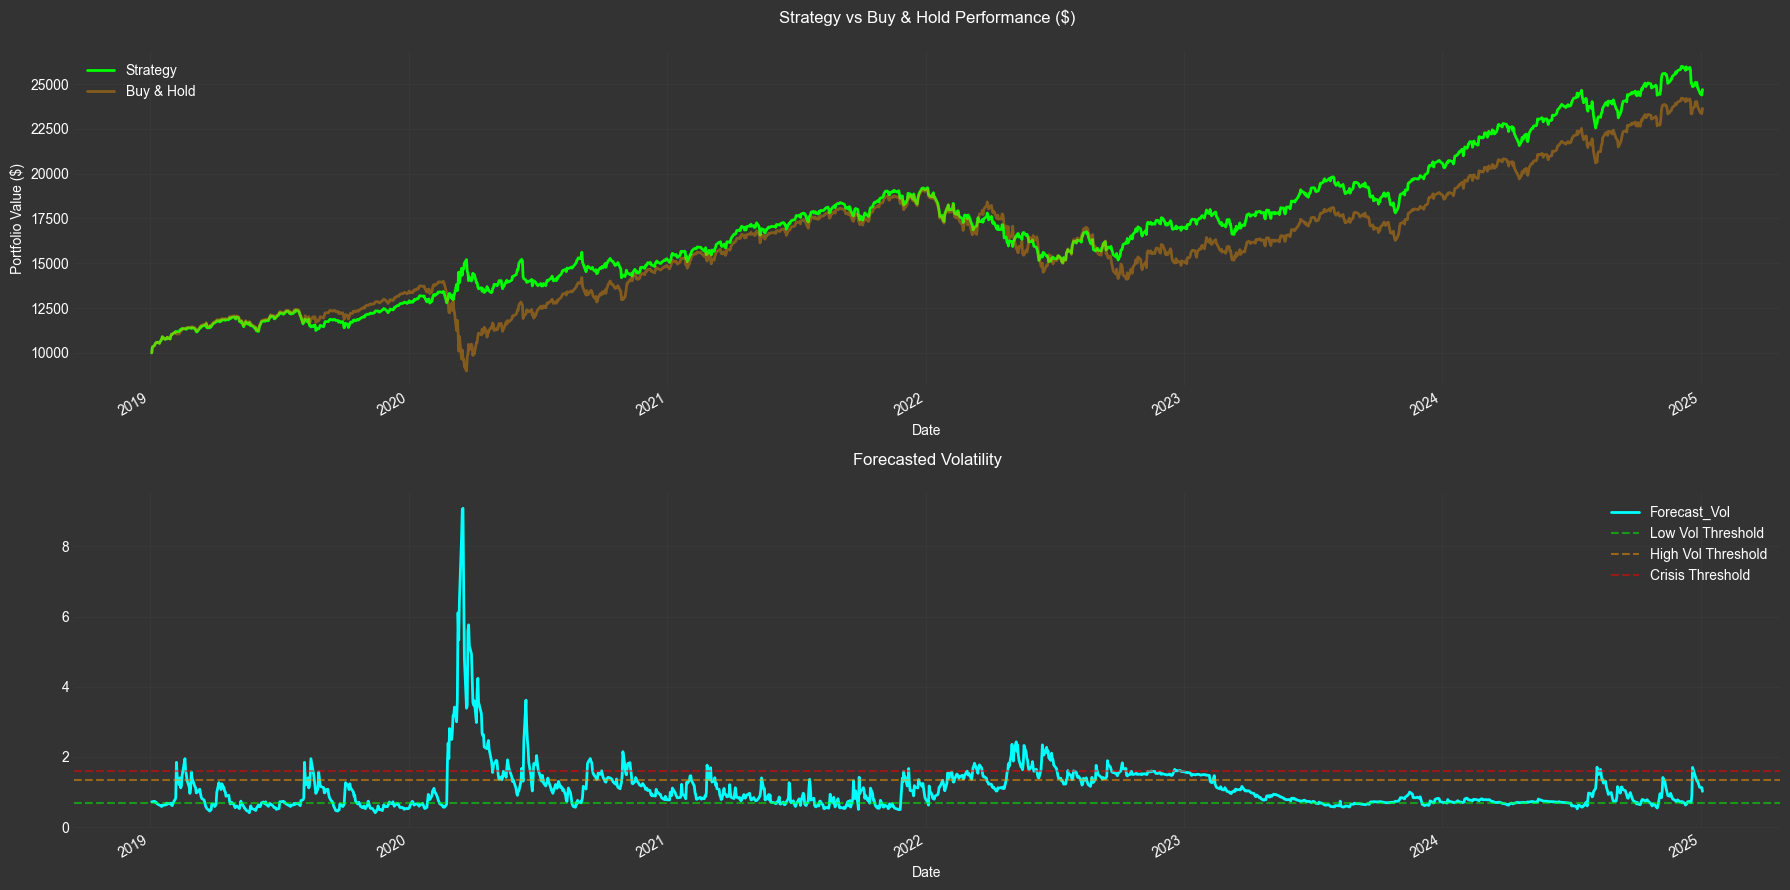


Performance Metrics:
Initial_Capital: $10,000.00
Final_Strategy_Equity: $24,692.27
Final_Buy_Hold_Equity: $23,637.10
Total_Return: 146.92%
Buy_Hold_Return: 136.37%
Annual_Return: 16.18%
Annual_Volatility: 14.74%
Sharpe_Ratio: 109.78%
Max_Drawdown: -21.73%

Regime Distribution:
Regime
Normal Vol    755
Low Vol       378
High Vol      227
Crisis        151
Name: count, dtype: int64

Average Position Sizes by Regime:
            Net_SPY_Position
Regime                      
Crisis                 -0.50
High Vol                0.65
Low Vol                 1.00
Normal Vol              1.00

Next Day Forecast:
Forecasted Volatility: 95.01%
Implied Regime: Normal Vol
Current Portfolio Value: $24,692.27


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = '#333333'
plt.rcParams['axes.facecolor'] = '#333333'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = '#444444'

lookback_period=125

def forecast_volatility(returns, lookback=lookback_period):
    """
    Forecast next day volatility using GARCH(1,1) model
    """
    if len(returns) < lookback:
        return None
    
    # Use the lookback period for fitting
    train_returns = returns[-lookback:]
    
    # Fit GARCH model
    model = arch.arch_model(train_returns, mean='Zero', vol='GARCH', p=2, q=1, dist='skewstudent')
    results = model.fit(disp='off', show_warning=False)
    
    # Get forecast for next day
    forecast = results.forecast(horizon=1)
    return np.sqrt(forecast.variance.values[-1][0])

# Initial capital
INITIAL_CAPITAL = 10000

# Download SPY data
start_date='2019-01-01'
spy = yf.download('SPY', start=start_date, end=datetime.now().strftime('%Y-%m-%d'))

# Calculate returns
# spy_returns = 100 * spy['Adj Close'].pct_change().dropna()
spy_returns = 100 * np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))

# Drop missing values (from the shift operation)
spy_returns = spy_returns.dropna()

# ________________Extend spy df for 365 days (approx. lookback_period trading days)____________
extra_days = 182
extended_start_date = (datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=extra_days)).strftime('%Y-%m-%d')
extended_spy = yf.download('SPY', start=extended_start_date, end=datetime.now().strftime('%Y-%m-%d'))
extended_spy_returns = 100 * np.log(spy['Adj Close'] / spy['Adj Close'].shift(1))
extended_spy_returns = extended_spy_returns.dropna()

# Initialize DataFrame for forecasts and regime classification
portfolio = pd.DataFrame(index=spy_returns.index)
portfolio['SPY_Returns'] = spy_returns
portfolio['Forecast_Vol'] = np.nan
portfolio['Regime'] = 'Normal Vol'

# Calculate rolling volatility forecasts
for i in range(len(portfolio)):
    if i < lookback_period:  # Start after we have enough data for lookback
        returns_slice = extended_spy_returns.iloc[:lookback_period+i]
        forecast = forecast_volatility(returns_slice)
        if forecast is not None:
            portfolio['Forecast_Vol'].iloc[i] = forecast
    else:
        returns_slice = spy_returns.iloc[:i]
        forecast = forecast_volatility(returns_slice)
        if forecast is not None:
            portfolio['Forecast_Vol'].iloc[i] = forecast

# Calculate regime thresholds based on historical forecasts
valid_forecasts = portfolio['Forecast_Vol'].dropna()
vol_25th = np.percentile(valid_forecasts, 25)
vol_75th = np.percentile(valid_forecasts, 75)
vol_90th = np.percentile(valid_forecasts, 90)

# Classify regimes based on forecasted volatility
portfolio.loc[portfolio['Forecast_Vol'] < vol_25th, 'Regime'] = 'Low Vol'
portfolio.loc[portfolio['Forecast_Vol'] > vol_75th, 'Regime'] = 'High Vol'
portfolio.loc[portfolio['Forecast_Vol'] > vol_90th, 'Regime'] = 'Crisis'

# Set position sizes based on regime
portfolio['SPY_Long_Position'] = np.where(portfolio['Regime'] == 'Low Vol', 1.0,
                                np.where(portfolio['Regime'] == 'Normal Vol', 1.0,
                                np.where(portfolio['Regime'] == 'High Vol', 0.75, 0.0)))

portfolio['SPY_Short_Position'] = np.where(portfolio['Regime'] == 'High Vol', -0.1,
                                 np.where(portfolio['Regime'] == 'Crisis', -0.5, 0.0))

# Calculate net SPY position
portfolio['Net_SPY_Position'] = portfolio['SPY_Long_Position'] + portfolio['SPY_Short_Position']

# Initialize equity tracking
portfolio['Strategy_Equity'] = INITIAL_CAPITAL
portfolio['Buy_Hold_Equity'] = INITIAL_CAPITAL

# Calculate dollar returns and equity
for i in range(1, len(portfolio)):
    # Previous day's equity
    prev_strategy_equity = portfolio['Strategy_Equity'].iloc[i-1]
    prev_buy_hold_equity = portfolio['Buy_Hold_Equity'].iloc[i-1]
    
    # Calculate transaction costs (0.1% of available equity when position changes)
    position_change = abs(portfolio['Net_SPY_Position'].iloc[i] - portfolio['Net_SPY_Position'].iloc[i-1])
    transaction_cost = prev_strategy_equity * 0.001 * position_change
    
    # Calculate strategy returns in dollars
    strategy_return_pct = portfolio['Net_SPY_Position'].iloc[i] * portfolio['SPY_Returns'].iloc[i] / 100
    strategy_dollar_return = prev_strategy_equity * strategy_return_pct
    
    # Update strategy equity
    portfolio.loc[portfolio.index[i], 'Strategy_Equity'] = (
        prev_strategy_equity + strategy_dollar_return - transaction_cost
    )
    
    # Calculate buy & hold returns in dollars
    buy_hold_return_pct = portfolio['SPY_Returns'].iloc[i] / 100
    buy_hold_dollar_return = prev_buy_hold_equity * buy_hold_return_pct
    
    # Update buy & hold equity
    portfolio.loc[portfolio.index[i], 'Buy_Hold_Equity'] = (
        prev_buy_hold_equity + buy_hold_dollar_return
    )

# Calculate performance metrics
strategy_returns = portfolio['Strategy_Equity'].pct_change().dropna()
buy_hold_returns = portfolio['Buy_Hold_Equity'].pct_change().dropna()

performance_metrics = {
    'Initial_Capital': INITIAL_CAPITAL,
    'Final_Strategy_Equity': portfolio['Strategy_Equity'].iloc[-1],
    'Final_Buy_Hold_Equity': portfolio['Buy_Hold_Equity'].iloc[-1],
    'Total_Return': (portfolio['Strategy_Equity'].iloc[-1] / INITIAL_CAPITAL - 1),
    'Buy_Hold_Return': (portfolio['Buy_Hold_Equity'].iloc[-1] / INITIAL_CAPITAL - 1),
    'Annual_Return': strategy_returns.mean() * 252,
    'Annual_Volatility': strategy_returns.std() * np.sqrt(252),
    'Sharpe_Ratio': strategy_returns.mean() / strategy_returns.std() * np.sqrt(252),
    'Max_Drawdown': (portfolio['Strategy_Equity'] / 
                    portfolio['Strategy_Equity'].cummax() - 1).min(),
}

# Plotting results
plt.figure(figsize=(18, 9))

# Plot 1: Equity Curves
ax1 = plt.subplot(2, 1, 1)
portfolio['Strategy_Equity'].plot(label='Strategy', color='#00ff00', linewidth=2)
portfolio['Buy_Hold_Equity'].plot(label='Buy & Hold', color='#ff9900', linewidth=2, alpha=0.4)
plt.title('Strategy vs Buy & Hold Performance ($)', pad=20)
plt.legend(facecolor='#333333', edgecolor='white')
plt.grid(True, alpha=0.3)
plt.ylabel('Portfolio Value ($)')

# Plot 2: Forecasted Volatility
ax2 = plt.subplot(2, 1, 2)
portfolio['Forecast_Vol'].plot(color='#00ffff', linewidth=2)
plt.axhline(y=vol_25th, color='#00ff00', linestyle='--', alpha=0.5, label='Low Vol Threshold')
plt.axhline(y=vol_75th, color='#ff9900', linestyle='--', alpha=0.5, label='High Vol Threshold')
plt.axhline(y=vol_90th, color='#ff0000', linestyle='--', alpha=0.5, label='Crisis Threshold')
plt.title('Forecasted Volatility', pad=20)
plt.legend(facecolor='#333333', edgecolor='white')
plt.grid(True, alpha=0.3)

# Plot 3: Regime Distribution
# ax3 = plt.subplot(3, 1, 3)
# colors = ['#00ff00', '#ffff00', '#ff9900', '#ff0000']
regime_counts = portfolio['Regime'].value_counts()
# regime_counts.plot(kind='bar', color=colors)
# plt.title('Regime Distribution', pad=20)
# plt.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
for metric, value in performance_metrics.items():
    if metric in ['Initial_Capital', 'Final_Strategy_Equity', 'Final_Buy_Hold_Equity']:
        print(f"{metric}: ${value:,.2f}")
    else:
        print(f"{metric}: {value:.2%}")

# Print regime distribution
print("\nRegime Distribution:")
print(regime_counts)

# Print average position sizes by regime
print("\nAverage Position Sizes by Regime:")
print(portfolio.groupby('Regime')[['Net_SPY_Position']].mean())

# Get the latest forecast for next day
latest_returns = spy_returns[-lookback_period:]
next_day_forecast = forecast_volatility(latest_returns)

# Print next day forecast
print("\nNext Day Forecast:")
print(f"Forecasted Volatility: {next_day_forecast:.2%}")
current_regime = 'Normal Vol'
if next_day_forecast < vol_25th:
    current_regime = 'Low Vol'
elif next_day_forecast > vol_90th:
    current_regime = 'Crisis'
elif next_day_forecast > vol_75th:
    current_regime = 'High Vol'
print(f"Implied Regime: {current_regime}")
print(f"Current Portfolio Value: ${portfolio['Strategy_Equity'].iloc[-1]:,.2f}")